In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from joblib import Parallel, delayed
%matplotlib inline

In [2]:
 # Generate complex-valued noise
def gen_noise(N, snr_db):
    # Do not forget np.sqrt(1/2) factor for CN circular noise!
    sigma = np.sqrt(1 / (2 * 10 ** (snr_db / 10)))
    z_re = np.random.normal(0, 1, size=(N,))
    z_im = np.random.normal(0, 1, size=(N,))
    return (z_re + 1j * z_im) * sigma  # The total power is 2 * sigma^2

In [3]:
# Implementation of parallel computation with the help of Parallel library
class ProgressParallel(Parallel):
    def __init__(self, use_tqdm=True, total=None, desc='', *args, **kwargs):
        self._use_tqdm = use_tqdm
        self._total = total
        self._desc = desc
        super().__init__(*args, **kwargs)

    def __call__(self, *args, **kwargs):
        with tqdm(disable=not self._use_tqdm, total=self._total, desc=self._desc) as self._pbar:
            return Parallel.__call__(self, *args, **kwargs)

# TQDM progress bar
    def print_progress(self):
        if self._total is None:
            self._pbar.total = self.n_dispatched_tasks
        self._pbar.n = self.n_completed_tasks
        self._pbar.refresh()

        
def simulate(snr_db_range, max_errors, experiment_func):
    
    def simulation(snr_db):
        n_errors, n_experiments = 0, 0
        while n_errors < max_errors:
            n_errors += experiment_func(snr_db)
            n_experiments += 1
        return n_errors / n_experiments
    
    p_e = np.asarray(ProgressParallel(n_jobs=-1, total=len(snr_db_range), desc=f'step:')([
        delayed(simulation)(snr_db) for snr_db in snr_db_range]))
    
    # Plot results:
    plt.plot(snr_db_range, p_e)
    plt.yscale('log')
    plt.xlabel('Signal-to-noise ratio [dB]')
    plt.ylabel('Error rate')
    plt.grid()
    plt.legend([2,4,8,16])

In [4]:
def get_H_rayleigh(n_tx, n_rx):
    return np.matrix(np.random.randn(n_rx, n_tx) + 1j * np.random.randn(n_rx, n_tx)) / np.sqrt(2 * n_tx)


# BPSK V-BLAST transmitter, CSI known at receiver only - equal power allocation
def generate_received_signal(n_tx, n_rx, snr_db):
    H = get_H_rayleigh(n_tx, n_rx)
    x = np.random.randint(0, 2, size=n_tx,)
    y = H * np.matrix(1 - 2 * x).T + np.matrix(gen_noise(n_rx, snr_db)).T
    return x, y, H

### Maximum likelihood MIMO detection routines

In [5]:
# Convert integer to binary array
def de2bi(val, out_len):
    val_array = [int(x) for x in list('{0:0b}'.format(val))]
    return [0] * (out_len - len(val_array)) + val_array

# Generate 2**N possible transmitted combinations
def gen_iwd_book(N):
    n_cwd = 2 ** N
    iwd_book = np.zeros((2 ** N, N))
    for i in range(n_cwd):
        iwd_book[i, :] = de2bi(i, N)
    return iwd_book


# Find the closest point to the received signal among all possible
# combinations transmitted
def ml_detector(snr_db, n_tx, n_rx):
    x, y, H = generate_received_signal(n_tx, n_rx, snr_db)

    iwd_book = gen_iwd_book(n_tx)
    iwd_book_bpsk = np.matrix(1 - 2 * iwd_book).T

    y_vec = H * iwd_book_bpsk
    distance = np.linalg.norm(y_vec - y, axis=0) ** 2
    iwd_best_id = np.argmin(distance)
    x_hat = iwd_book[iwd_best_id, :]
    return np.mean(x_hat != x)


def mse_detector(snr_db, n_tx, n_rx):
    x, y, H = generate_received_signal(n_tx, n_rx, snr_db)
    x_hat = np.linalg.pinv(H) * y
    decoded = []
    for i in range (x_hat.shape[0]):
        if (x_hat[i] > 0):
            decoded.append(0)
        else:
            decoded.append(1)
    return np.mean(decoded != x)

def create_words(code):
    # Create all possible information words
    d = np.zeros((2**k,k),dtype=bool)
    for i in range(1,2**k):
        d[i]= inc_bool(d[i-1])

    # Create sets of all possible codewords (codebook)
    if code == 'polar':   

        A = polar_design_awgn(N, k, design_snr_dB=0)  # logical vector indicating the nonfrozen bit locations 
        x = np.zeros((2**k, N),dtype=bool)
        u = np.zeros((2**k, N),dtype=bool)
        u[:,A] = d

        for i in range(0,2**k):
            x[i] = polar_transform_iter(u[i])
        return x, d, A

    elif code == 'random':

        np.random.seed(4267)   # for a 16bit Random Code (r=0.5) with Hamming distance >= 2
        x = np.random.randint(0,2,size=(2**k,N), dtype=bool)
        return x, d

## Numerical experiments

Evaluating the ML detector


step::   0%|          | 0/5 [00:00<?, ?it/s]

Evaluating the MSE detector


step::   0%|          | 0/5 [00:00<?, ?it/s]

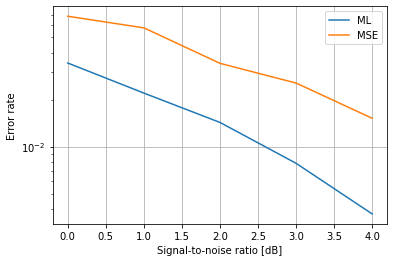

In [6]:
snr_range = np.arange(-0, 5)
n_tx = 4  # Transmitter antenna count
n_rx = 8  # Receiver antenna count

n_errors = 100 # Maximum number of errors
print('Evaluating the ML detector')
simulate(snr_range, n_errors,
    lambda x: ml_detector(x, n_tx, n_rx)
)

print('Evaluating the MSE detector')
simulate(snr_range, n_errors,
    lambda x: mse_detector(x, n_tx, n_rx)
)

plt.legend(['ML', 'MSE'])
plt.grid()